In [84]:
# Importing necessary libraries for data handling, visualization, and building the CNN model
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models # Layers for building the CNN, models for sequential model
from sklearn.model_selection import train_test_split # Although data is split in npz, this is useful for general workflow
from sklearn.preprocessing import LabelBinarizer, LabelEncoder # For encoding labels
from sklearn.metrics import classification_report, confusion_matrix # For evaluating model performance
from tensorflow.keras.utils import to_categorical # For one-hot encoding labels
import os # For interacting with the operating system (useful for file paths)
from PIL import Image # For image handling, although not strictly needed for npz loading

In [85]:
# Loading Data from the .npz file
# Specify the path to your .npz file
npz_file_path = "ORL_faces.npz" # Assuming the file is in the current directory

try:
    # Load the data from the .npz file
    data = np.load(npz_file_path)

    # Print the keys available in the npz file to understand its structure
    print("Keys available in the npz file:", data.keys())

    # Load data into training and testing sets using the correct keys from the npz file
    X_train = data['trainX'] # Training images
    y_train = data['trainY'] # Training labels
    X_test = data['testX']   # Testing images
    y_test = data['testY']   # Testing labels


    # Print confirmation and shapes of the loaded data
    print(f"Data loaded successfully from {npz_file_path}")
    print(f"Training images shape: {X_train.shape}")
    print(f"Training labels shape: {y_train.shape}")
    print(f"Testing images shape: {X_test.shape}")
    print(f"Testing labels shape: {y_test.shape}")


    # Close the file after loading to free up resources
    data.close()

except FileNotFoundError:
    # Handle the case where the npz file is not found
    print(f"Error: The file '{npz_file_path}' was not found. Please check the path.")
except KeyError as e:
    # Handle the case where expected keys are not found in the npz file
    print(f"Error: Could not find the expected key in the npz file. Details: {e}")
    print("Please check the keys in your npz file.")
except Exception as e:
    # Handle any other exceptions that might occur during loading
    print(f"An error occurred: {e}")

Keys available in the npz file: KeysView(NpzFile 'ORL_faces.npz' with keys: testY, testX, trainX, trainY)
Data loaded successfully from ORL_faces.npz
Training images shape: (240, 10304)
Training labels shape: (240,)
Testing images shape: (160, 10304)
Testing labels shape: (160,)


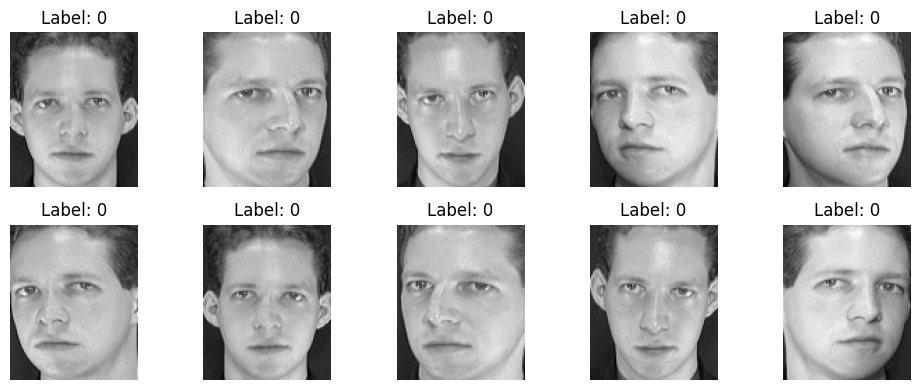

In [86]:
# Visualize sample images from the training set
plt.figure(figsize=(10, 4))
# Assuming img_height and img_width are defined from previous cells (112 and 92 respectively)
# Display the first 10 images from the training set (X_train)
# Reshape the flattened images back to their original dimensions for display
for i in range(10):
    plt.subplot(2, 5, i + 1)
    # Reshape the flattened image (10304,) back to (112, 92) for visualization
    img = X_train[i].reshape(img_height, img_width)
    plt.imshow(img, cmap='gray') # Display the image in grayscale
    # Get the label for the current image
    # Check if y_train is one-hot encoded or not
    if y_train.ndim > 1: # If labels are one-hot encoded
        label = np.argmax(y_train[i]) # Get the index (class) with the highest probability
    else: # If labels are integer encoded
        label = y_train[i]
    plt.title(f"Label: {label}") # Set the title to the image's label
    plt.axis('off') # Hide the axes
plt.tight_layout() # Adjust layout to prevent titles/labels from overlapping
plt.show() # Display the plot

In [87]:
# Preprocessing Step 1: Encode the labels
from sklearn.preprocessing import LabelEncoder # Import LabelEncoder
from tensorflow.keras.utils import to_categorical # Import to_categorical for one-hot encoding

# Assuming y_train and y_test are the loaded labels (integer or string format)
label_encoder = LabelEncoder() # Initialize LabelEncoder
# Fit the encoder on the training labels and transform both training and testing labels
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Convert the integer encoded labels to categorical (one-hot encoding)
y_train_categorical = to_categorical(y_train_encoded)
y_test_categorical = to_categorical(y_test_encoded)

print("Labels encoded and converted to categorical.")
# Print the shapes of the categorical labels to verify the transformation
print(f"y_train_categorical shape: {y_train_categorical.shape}")
print(f"y_test_categorical shape: {y_test_categorical.shape}")

Labels encoded and converted to categorical.
y_train_categorical shape: (240, 20)
y_test_categorical shape: (160, 20)


In [88]:
# Reshaping images for CNN input and normalize pixel values
# Assuming img_height and img_width are defined (112 and 92 respectively)
# Assuming X_train and X_test are the loaded image data (flattened)

# Reshape the flattened images to (num_samples, img_height, img_width, 1) for grayscale CNN input
# The '1' indicates the single channel for grayscale images
X_train_reshaped = X_train.reshape(X_train.shape[0], img_height, img_width, 1)
X_test_reshaped = X_test.reshape(X_test.shape[0], img_height, img_width, 1)

# Normalize pixel values to be between 0 and 1
# This is done by dividing each pixel value by the maximum possible value (255 for 8-bit images)
X_train_normalized = X_train_reshaped / 255.0
X_test_normalized = X_test_reshaped / 255.0

# Print confirmation and the shapes of the reshaped and normalized image data
print(f"Images reshaped and normalized: X_train_normalized shape {X_train_normalized.shape}, X_test_normalized shape {X_test_normalized.shape}")

Images reshaped and normalized: X_train_normalized shape (240, 112, 92, 1), X_test_normalized shape (160, 112, 92, 1)


In [89]:
# Build the CNN model
model = models.Sequential([
    # First Convolutional Layer: 32 filters, 3x3 kernel, ReLU activation
    # input_shape defines the shape of the input images (height, width, channels)
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 1)),
    # First MaxPooling Layer: Reduces spatial dimensions, 2x2 pool size
    layers.MaxPooling2D((2, 2)),
    # Second Convolutional Layer: 64 filters, 3x3 kernel, ReLU activation
    layers.Conv2D(64, (3, 3), activation='relu'),
    # Second MaxPooling Layer: Reduces spatial dimensions, 2x2 pool size
    layers.MaxPooling2D((2, 2)),
    # Third Convolutional Layer: 128 filters, 3x3 kernel, ReLU activation
    layers.Conv2D(128, (3, 3), activation='relu'),
    # Third MaxPooling Layer: Reduces spatial dimensions, 2x2 pool size
    layers.MaxPooling2D((2, 2)),
    # Flatten Layer: Flattens the output from convolutional layers into a 1D vector
    layers.Flatten(),
    # First Dense (Fully Connected) Layer: 128 units, ReLU activation
    layers.Dense(128, activation='relu'),
    # Output Dense Layer: Number of units equals the number of classes, softmax activation for multi-class classification
    layers.Dense(len(label_encoder.classes_), activation='softmax')
])

# Compiled the model
# optimizer: Algorithm used to update model weights during training (adam is a common choice)
# loss: Function to minimize during training (categorical_crossentropy is used for multi-class classification with one-hot encoded labels)
# metrics: Metrics to monitor during training and evaluation (accuracy is a common choice)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print a summary of the model's architecture and the number of parameters
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)              │ (None, 110, 90, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 55, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 53, 43, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 26, 21, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 24, 19, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 12, 9, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 13824)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │     1,769,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 20)             │         2,580 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,864,852 (7.11 MB)

 Trainable params: 1,864,852 (7.11 MB)

 Non-trainable params: 0 (0.00 B)

In [90]:
#  Train the model
# Feed the preprocessed and reshaped/normalized training data and one-hot encoded labels to the model
# epochs: Number of times to iterate over the entire training dataset
# validation_split: Percentage of the training data to be used for validation
history = model.fit(X_train_normalized, y_train_categorical, epochs=10, validation_split=0.2)

Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 593ms/step - accuracy: 0.0641 - loss: 3.0153 - val_accuracy: 0.0000e+00 - val_loss: 3.5117
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 554ms/step - accuracy: 0.0594 - loss: 2.8914 - val_accuracy: 0.0000e+00 - val_loss: 4.6498
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 545ms/step - accuracy: 0.0753 - loss: 2.7715 - val_accuracy: 0.0000e+00 - val_loss: 6.4347
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 532ms/step - accuracy: 0.1991 - loss: 2.6147 - val_accuracy: 0.0000e+00 - val_loss: 8.9210
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 638ms/step - accuracy: 0.4199 - loss: 2.3364 - val_accuracy: 0.0000e+00 - val_loss: 14.7947
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 565ms/step - accuracy: 0.4952 - loss: 1.7708 - val_accuracy: 0.0000e+00 - val_loss: 25.0181
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 711ms/step - accuracy: 0.6920 - loss: 1.1483 - val_accuracy: 0.0000e+00 - val_loss: 34.7644
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 541ms/step - accuracy: 0.8750 - loss: 0.6206 - v

In [91]:
#  Evaluate the model on the test set
# Use the preprocessed and reshaped/normalized testing data and one-hot encoded labels
# verbose=2: Displays the progress bar
test_loss, test_acc = model.evaluate(X_test_normalized, y_test_categorical, verbose=2)
# Print the final test accuracy
print(f"\nTest accuracy: {test_acc}")

5/5 - 1s - 140ms/step - accuracy: 0.7125 - loss: 11.3699

Test accuracy: 0.7124999761581421


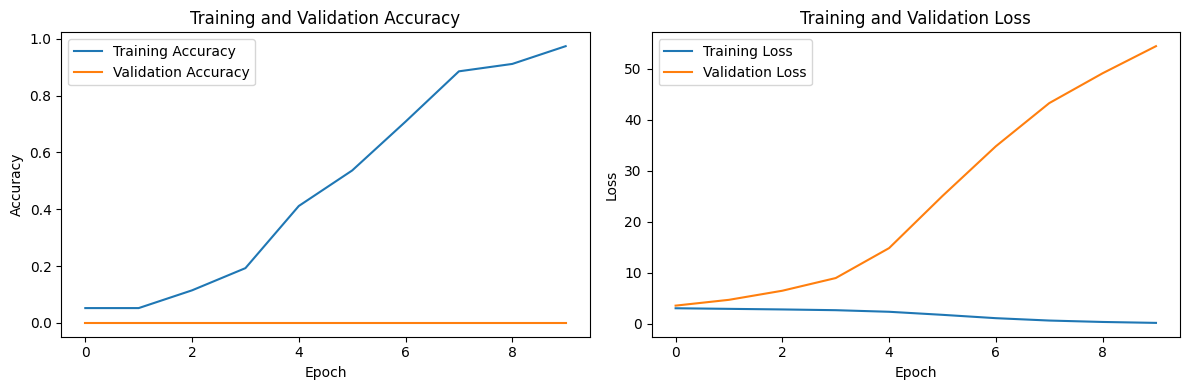

In [92]:
# Plot training and validation accuracy and loss
plt.figure(figsize=(12, 4))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()